# Exploring CNN Architectures for MNIST Classification
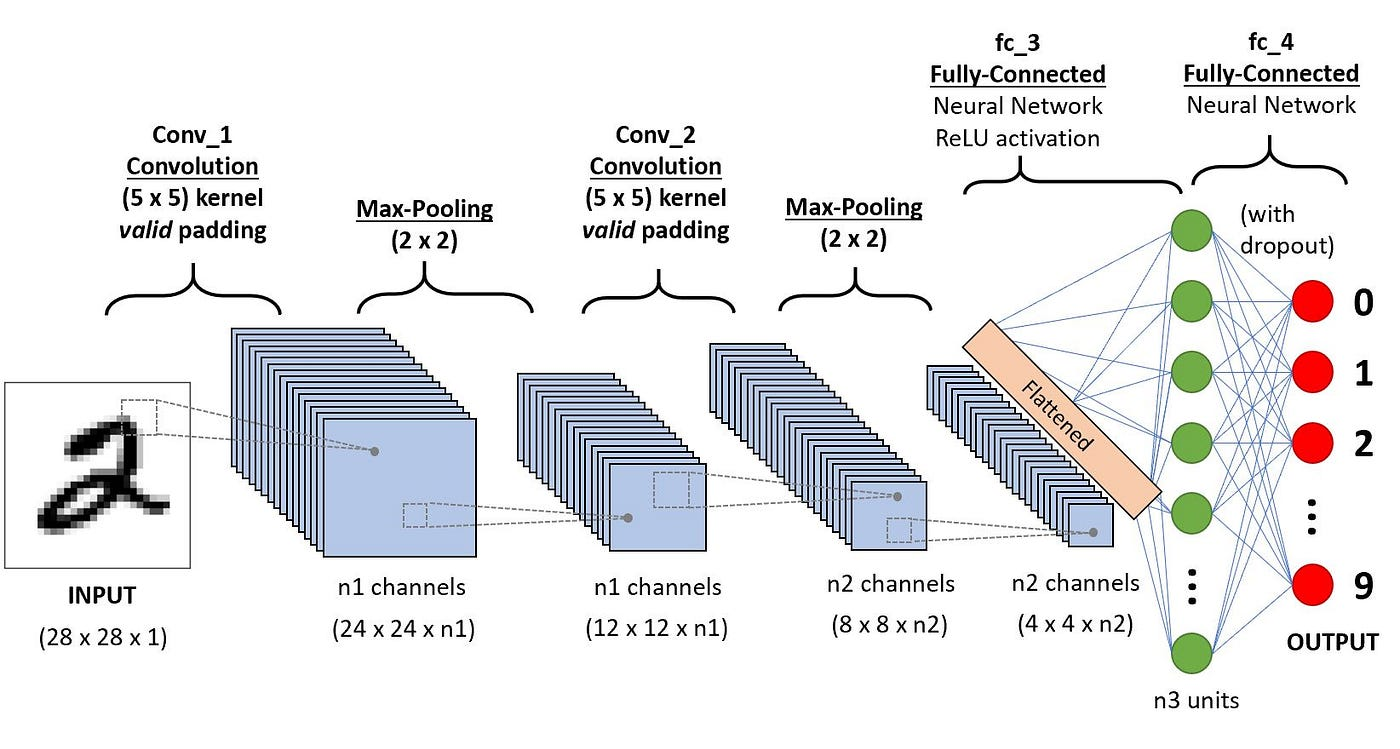

In this notebook, we will explore several Convolutional Neural Network (CNN) architectures for the task of MNIST classification. The MNIST dataset consists of 28x28 grayscale images of handwritten digits, making it an ideal benchmark for testing the effectiveness of different CNN models. We will implement a variety of CNN architectures, including a custom-designed model, PyTorch's standard CNN, and an AlexNet-inspired model, to observe the impact of different layers, activation functions, and regularization techniques on classification performance. Throughout the notebook, we will also visualize activations and kernels to improve the interpretability of the models, shedding light on how these networks learn to identify key features of the digits. The goal is to understand how various CNN architectures influence the accuracy of digit classification and to explore the strengths and weaknesses of each design choice.

**This notebook is authored by**

**Orestis Antonis Makris** Chair ACM Student Chapter Upatras

**First Step**


In this first step, we import the necessary libraries and dependencies for building and training our Neural Networks (NN) using PyTorch. We also import libraries for data manipulation, visualization, and model evaluation.

In [1]:
# Import PyTorch and related libraries for building and training neural networks
import torch  # PyTorch for tensor operations and model creation
import torch.nn as nn  # Neural network module for building layers
import torch.nn.functional as F  # Contains activation functions and other operations
import torch.optim as optim  # Optimizers for training models

# Import torchvision for dataset handling and transforms
import torchvision  # For image datasets like CIFAR-10 and MNIST
import torchvision.transforms as transforms  # For preprocessing images

# Import libraries for visualization and evaluation
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import numpy as np  # For numerical operations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For evaluating model performance
import seaborn as sns  # For creating heatmaps (useful for confusion matrix)

**Check for GPU or fall back to CPU**

In this cell, we check if CUDA (GPU support) is available. If it's not, we fall back to using the CPU for training the model.

In [2]:
# Check if CUDA (GPU support) is available, else use CPU for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Transformations:**

Next, we define the transformations that will be applied to the dataset. Specifically, we convert the images to tensors and normalize them to a mean of 0.5 and a standard deviation of 0.5

In [3]:
# Define transformations: Convert images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

**Load the Training Dataset**

In this step, we load the MNIST training dataset. MNIST (Modified National Institute of Standards and Technology) is a popular dataset consisting of 60,000 images of handwritten digits (0-9), each 28x28 pixels in size. The dataset is used widely for benchmarking image classification models. We apply the defined transformations to convert the images to tensors and normalize them.

We then load the data in batches of 64 images. Batching is a technique used to divide the data into smaller subsets (batches) so that the model can process them efficiently during training. Instead of training the model on all 60,000 images at once (which would require a large amount of memory), we feed the model one batch at a time. This helps speed up training, improves generalization, and makes it possible to work with large datasets.

In [4]:
# Load the MNIST training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for batching and shuffling the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Load the Test Dataset**

Next, we load the MNIST test dataset, which contains 10,000 images of handwritten digits (0-9). These images are similar to the training data but are kept separate to evaluate the performance of the model on unseen data.

Unlike the training dataset, we do not shuffle the test data. Shuffling is useful during training to ensure the model doesn’t memorize the order of data, but for testing, we want to evaluate the model's performance on the exact same data every time to get a consistent result. We still load the data in batches of 64 for efficiency.

In [5]:
# Load the MNIST test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


***Additional Information:***

Batch Size: As with the training data, the batch size of 64 allows the model to process data efficiently. Testing in batches helps evaluate the model's performance without overwhelming the system's memory.

Shuffling: Shuffling is not performed on the test set because during testing, we want to evaluate the model on the same set of images in the same order each time. This ensures that we are getting a consistent performance measurement.

DataLoader: Just like for the training dataset, the DataLoader handles the batching and loading of data for the test set. However, since we are not training, there is no need to shuffle or apply data augmentation techniques during testing.

**Visualize Sample Images**

In this cell, we visualize a few images from the MNIST training dataset along with their corresponding labels

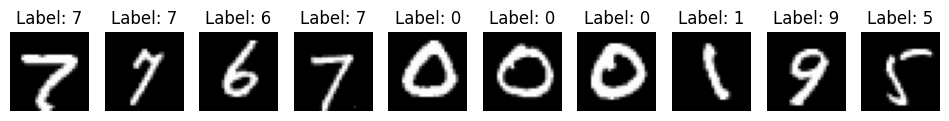

In [6]:
# Visualizing some images from the MNIST training dataset

# Get a batch of data
examples = iter(trainloader)
example_data, example_labels = next(examples)

# Create a subplot to display images in a 1x10 grid
fig, axes = plt.subplots(1, 10, figsize=(12, 6))
for i in range(10):
    ax = axes[i]
    ax.imshow(example_data[i][0], cmap='gray')  # Display the image in grayscale
    ax.set_title(f'Label: {example_labels[i].item()}')  # Display the label of the image
    ax.axis('off')  # Turn off axis for better visualization

plt.show()  # Show the images

**Visualizing an Image as a Matrix with Axis Labels and Color Bar**

In this step, we visualize one of the MNIST images as a matrix (2D tensor). We add axis labels to show the image dimensions, and use a color bar to represent the pixel intensity values, which range from 0 (black) to 1 (white). This will help you better understand how the image is represented as numerical data in a neural network

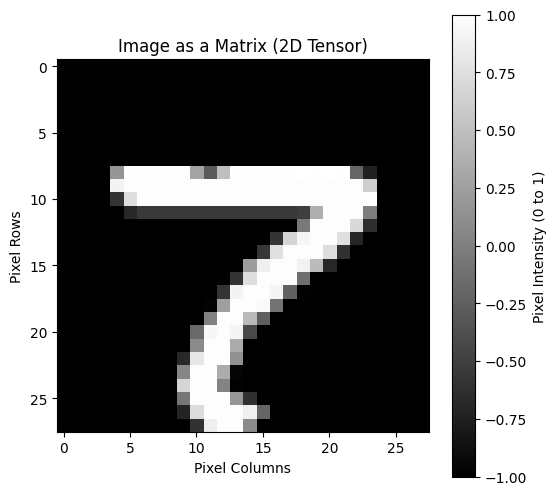

Shape of the image tensor: (28, 28)
Image as a matrix (first 5x5 pixels):
[[-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]]


In [7]:
# Visualize one image as a matrix (tensor)
image = example_data[0][0]  # Take the first image in the batch

# Convert the image to a numpy array for easy display
image_matrix = image.numpy()

# Plot the image matrix with axis labels
plt.figure(figsize=(6,6))
cax = plt.imshow(image_matrix, cmap='gray')  # Display the image in grayscale
plt.title("Image as a Matrix (2D Tensor)")
plt.xlabel("Pixel Columns")  # Label for x-axis (columns of pixels)
plt.ylabel("Pixel Rows")     # Label for y-axis (rows of pixels)
plt.axis('on')  # Turn on axis to see the labels

# Add a color bar to show pixel intensity range
plt.colorbar(cax, label="Pixel Intensity (0 to 1)")  # Color bar with intensity range

# Display the image matrix
plt.show()

# Print the shape and matrix values
print(f"Shape of the image tensor: {image_matrix.shape}")
print(f"Image as a matrix (first 5x5 pixels):\n{image_matrix[:5, :5]}")  # Display first 5x5 part of the image matrix


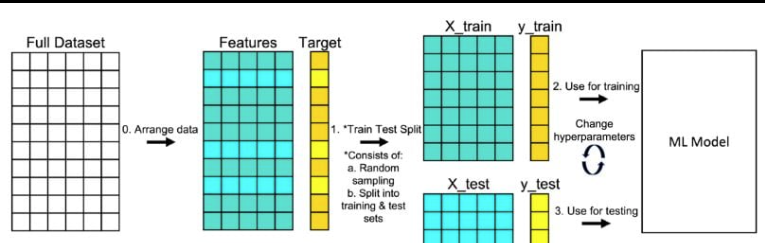
The reasoning behind splitting datasets into training and test sets ensures that machine learning models are properly trained and evaluated. The model’s ability to generalize to unseen data is critical for real-world applications.

**Explanation of Dataset Splitting:**
Training Set (Typically 80-90% of the Data):


*   The training set contains the majority of the data and is used to train the machine learning model. During training, the model learns patterns and relationships in the data by adjusting its parameters based on the inputs and their corresponding outputs (labels).
*   The more data you use for training, the better the model can generalize, as long as it's not overfitting to the training data.


**Test Set (Typically 10-20% of the Data):**



*   The test set is a smaller portion of the data that is not used during training. It is reserved for evaluating the model's performance after training is complete.

*   The test set simulates real-world data the model hasn't seen before, allowing you to check how well the model generalizes to unseen examples. A model that performs well on the test set is considered to have good generalization, which is the ultimate goal.

*   The 80-20 split is often used because it provides a good balance between having enough data for training while also keeping a sufficient amount of data to evaluate performance. However, this ratio can change depending on the size of the dataset and the problem at hand. For example, with a large dataset, the training set might take up 90% of the data, leaving only 10% for testing.


In this step, we print the number of samples in both the training and test datasets. This helps us understand the size of the dataset we're working with and the number of images available for training and testing. Typically, datasets are divided into a training set and a test set. The training set is used to train the model, while the test set is used to evaluate its performance on data it hasn't seen before. A common split ratio is 80-20, meaning 80% of the data is used for training, and 20% is used for testing. However, the exact ratio may vary depending on the dataset size and the problem being solved. For example, MNIST uses 60,000 training images and 10,000 test images, which is approximately an 85-15 split.

In [8]:
# Print the number of samples in the training and test datasets
print(f"Number of samples in the training set: {len(trainset)}")
print(f"Number of samples in the test set: {len(testset)}")

Number of samples in the training set: 60000
Number of samples in the test set: 10000


In this step, we load a batch of images and their corresponding labels from the training dataset using the trainloader. The trainloader is responsible for batching the dataset into manageable parts, which are then fed into the neural network during training. This code retrieves a batch of images and their labels, allowing us to visualize how the data is structured.

In [9]:
# Load a batch of images and labels from the training dataset
images, labels = next(iter(trainloader))

# Show the shape of the images and labels
print(f"Shape of the images batch: {images.shape}")
print(f"Shape of the labels batch: {labels.shape}")


Shape of the images batch: torch.Size([64, 1, 28, 28])
Shape of the labels batch: torch.Size([64])


**Images Batch (images.shape):**

This will typically have the shape [batch_size, channels, height, width]. For example, for MNIST, it will have the shape [64, 1, 28, 28], where:

*  64 is the batch size (number of images in the batch),

*  1 is the number of channels (since MNIST images are grayscale),

*  28 and 28 are the height and width of the images (28x28 pixels).

**Labels Batch (labels.shape):**

This will have the shape [batch_size], where each entry corresponds to the label (digit) of the image in the batch. For MNIST, this will be a 1D tensor of shape [64] where each value is an integer representing the digit (0-9).

---------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------

# **CNN**

In this step, we define a convolutional neural network (CNN) model for classifying MNIST images. The model consists of three convolutional layers followed by pooling layers and a fully connected layer at the end. This architecture is designed to progressively extract higher-level features from the input images. We also use global average pooling to reduce the dimensionality before passing the data to the fully connected layer. The model is then moved to the appropriate device (GPU or CPU).


# **CNN Layers:**

**First Convolutional Layer (cnn1):**

This layer has 32 filters, each with a size of 3x3. It operates on the input image of size 28x28, preserving the spatial dimensions using padding (padding=1), resulting in an output of size 28x28. After applying this layer, we downsample the output using max pooling, which reduces the size to 14x14.

**Second Convolutional Layer (cnn2):**

Similar to the first layer but with 64 filters. The output size is 14x14, and max pooling reduces it to 7x7.
Third Convolutional Layer (cnn3): This layer increases the number of filters to 128. It outputs a feature map of size 7x7, and global average pooling is applied, reducing it to a single value (1x1).

**Global Average Pooling (pool3)**

 Unlike typical max pooling, global average pooling averages the entire feature map (from 7x7 to 1x1). This helps to reduce overfitting by forcing the network to learn global features, rather than relying on local features.

**Fully Connected Layer (fc):**

After the CNN layers and pooling, the output is flattened into a vector (with size 128) and passed through a fully connected layer that outputs the final predictions for the 10 classes (digits 0-9 in MNIST).

**Model Initialization:**

The model is initialized, and the device variable is used to place the model on either the GPU (if available) or CPU.


Why use multiple convolutional layers?

Each convolutional layer extracts increasingly complex features from the input image, starting from basic edge and texture detection in the first layers to more abstract features in the deeper layers.

In [10]:
# Define the CNN model for MNIST classification
class BetterMNISTCNN(nn.Module):
    def __init__(self):
        super(BetterMNISTCNN, self).__init__()

        # First Convolutional Layer: 28x28 -> 28x28
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14

        # Second Convolutional Layer: 14x14 -> 14x14
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7

        # Third Convolutional Layer: 7x7 -> 7x7
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling -> 1x1

        # Fully connected layer: 128 -> 10 (for 10 classes)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        # Apply first convolutional layer, then pooling
        x = torch.relu(self.cnn1(x))
        x = self.pool1(x)

        # Apply second convolutional layer, then pooling
        x = torch.relu(self.cnn2(x))
        x = self.pool2(x)

        # Apply third convolutional layer, then pooling
        x = torch.relu(self.cnn3(x))
        x = self.pool3(x)  # Global Average Pooling to 1x1

        # Flatten the tensor to pass it through the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten

        # Final fully connected layer to get predictions for 10 classes
        x = self.fc(x)
        return x

# Initialize the model and move it to the GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetterMNISTCNN().to(device)


# Parameters for Training


In this step, we define the loss function, optimizer, and learning rate scheduler for the model. The loss function is crucial for training the network, as it quantifies how well the model's predictions match the actual labels. The optimizer adjusts the model's weights based on the loss, and the scheduler helps in controlling the learning rate during training to improve convergence.

**Loss Function (criterion):**

**nn.CrossEntropyLoss(): **

This is the loss function commonly used for multi-class classification problems like MNIST. It combines log_softmax and nll_loss in one function. It expects the raw logits (before applying softmax) from the model and the class indices (0-9 for MNIST) as targets. The goal is to minimize this loss during training.
Optimizer (optimizer):

**optim.AdamW():**

 The AdamW optimizer is an improved version of the Adam optimizer that includes weight decay (L2 regularization) to prevent overfitting. It adapts the learning rate for each parameter and includes a "corrected" version of momentum.

lr=0.001: Sets the learning rate to 0.001, which is a commonly used starting value for AdamW.

**The learning rate (lr)** is a crucial hyperparameter in neural network training that determines the size of the steps taken towards the optimal solution. It controls how much the model’s parameters are adjusted during each update in response to the error.

**High learning rate:** If you jump too high, you might overshoot the target and miss it, wasting time and effort.

**Low learning rate:** If your jump is too small, it might take you forever to get close to the target, even though you are making progress.

**Optimal learning rate:** The right jump height allows you to reach the target efficiently without overshooting or taking too long.

**Why Cross-Entropy Loss?**

This loss function is well-suited for classification tasks where the output is a probability distribution across multiple classes. In the case of MNIST, we are predicting one of 10 possible digits, so cross-entropy calculates the difference between the predicted probability and the actual class label.
Why Use AdamW Optimizer? AdamW provides an improved way to handle weight decay and performs better in many tasks by using both adaptive learning rates and regularization.


In [11]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay


In [12]:
print(f'Model is running on: {next(model.parameters()).device}')


Model is running on: cuda:0


# Training the Model

In this section, we perform the training of the BetterMNISTCNN model. We use the training dataset (trainloader) to train the model and the test dataset (testloader) to evaluate the model's performance at the end of each epoch.

The training process involves the following steps:

**Forward Pass:** For each batch of images, we send the data through the model to obtain the predicted outputs.
Loss Calculation: The predicted outputs are compared with the true labels to calculate the loss using the Cross-Entropy Loss function.


**Backward Pass:** We compute the gradients of the loss with respect to the model parameters, which tells us how to adjust the parameters to reduce the loss.
Optimization: The optimizer (AdamW) updates the model's parameters based on the computed gradients.


**Epochs:** This process is repeated for a specified number of epochs (24 in this case). After each epoch, we evaluate the model on the test dataset to calculate its accuracy.

We track the average training loss for each epoch to monitor how well the model is learning. Additionally, we evaluate the model on the test set to track the accuracy at each epoch and assess the model's generalization performance.



In [13]:
# Training loop for the model
num_epochs = 24  # Number of times we will iterate over the entire dataset
train_losses = []  # List to store the average loss per epoch
test_accuracies = []  # List to store the test accuracy per epoch

# Start training for the given number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (important for layers like dropout, batch normalization)
    running_loss = 0.0  # Variable to accumulate the loss for each batch in the epoch

    # Iterate over each batch of data in the training set
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move the data to the correct device (GPU/CPU)

        # Forward pass: Get model predictions
        outputs = model(images)

        # Compute the loss between predictions and true labels
        loss = criterion(outputs, labels)

        # Zero the gradients before the backward pass (important to prevent accumulation of gradients from previous batches)
        optimizer.zero_grad()

        # Backward pass: Compute gradients of the loss with respect to model parameters
        loss.backward()

        # Perform optimization step: Update the weights of the model
        optimizer.step()

        # Accumulate the loss for the current batch
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)  # Append the average loss for this epoch to the list
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}')  # Print the average loss for this epoch

    # Evaluate the model on the test dataset
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    correct = 0  # Variable to count the number of correct predictions
    total = 0  # Variable to count the total number of predictions

    # Disable gradient calculation during evaluation for efficiency
    with torch.no_grad():
        # Iterate over each batch of data in the test set
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move test data to the correct device
            outputs = model(images)  # Get predictions for the batch

            # Get the class with the highest predicted score for each image
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of predictions and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy of the model on the test dataset
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)  # Append the accuracy for this epoch to the list
    print(f'Accuracy on the test set: {accuracy:.2f}%')  # Print the test accuracy for this epoch


Epoch [1/24], Loss: 0.6433
Accuracy on the test set: 94.71%
Epoch [2/24], Loss: 0.1799
Accuracy on the test set: 96.12%
Epoch [3/24], Loss: 0.1281
Accuracy on the test set: 97.12%
Epoch [4/24], Loss: 0.0972
Accuracy on the test set: 97.25%
Epoch [5/24], Loss: 0.0795
Accuracy on the test set: 97.72%
Epoch [6/24], Loss: 0.0661
Accuracy on the test set: 98.44%
Epoch [7/24], Loss: 0.0548
Accuracy on the test set: 98.31%
Epoch [8/24], Loss: 0.0478
Accuracy on the test set: 98.60%
Epoch [9/24], Loss: 0.0411
Accuracy on the test set: 98.90%
Epoch [10/24], Loss: 0.0369
Accuracy on the test set: 98.66%
Epoch [11/24], Loss: 0.0320
Accuracy on the test set: 98.88%
Epoch [12/24], Loss: 0.0285
Accuracy on the test set: 98.77%
Epoch [13/24], Loss: 0.0251
Accuracy on the test set: 99.14%
Epoch [14/24], Loss: 0.0226
Accuracy on the test set: 99.04%
Epoch [15/24], Loss: 0.0205
Accuracy on the test set: 99.13%
Epoch [16/24], Loss: 0.0187
Accuracy on the test set: 98.93%
Epoch [17/24], Loss: 0.0181
Accur

# Key Points of the Training Process:

**Epochs and Batches:**

We train for a total of 24 epochs, meaning we iterate over the entire training dataset 24 times. Each time we iterate over the dataset, we break it into smaller batches (size 64 in this case), which are processed one by one.

**Loss Calculation:**

The loss function used is Cross-Entropy Loss, which measures how far the model's predictions are from the true labels. A lower loss indicates better performance.

**Backpropagation and Optimization:**

After calculating the loss, we perform backpropagation (loss.backward()) to compute the gradients, and then the optimizer (optimizer.step()) updates the model's parameters.

**Test Evaluation:**

 After each epoch, the model is evaluated on the test dataset without updating the model weights, and the accuracy is calculated to monitor the model's performance.



By tracking both the loss and accuracy, we can monitor how well the model is performing on both the training and test sets over time.

# Plotting Training Loss and Test Accuracy:

After training the model, it's important to visualize the training loss and test accuracy over the course of the epochs to evaluate the model's performance. The training loss helps us understand how well the model is learning, and the test accuracy shows how well the model generalizes to unseen data.

Training Loss: This graph displays the average loss per epoch on the training set. As the model learns, we expect the training loss to decrease.
Test Accuracy: This graph shows the accuracy on the test set after each epoch. We expect the accuracy to increase as the model improves.
By plotting these two metrics, we can visually track the learning process and check for potential overfitting (where the model performs well on the training data but poorly on the test data).

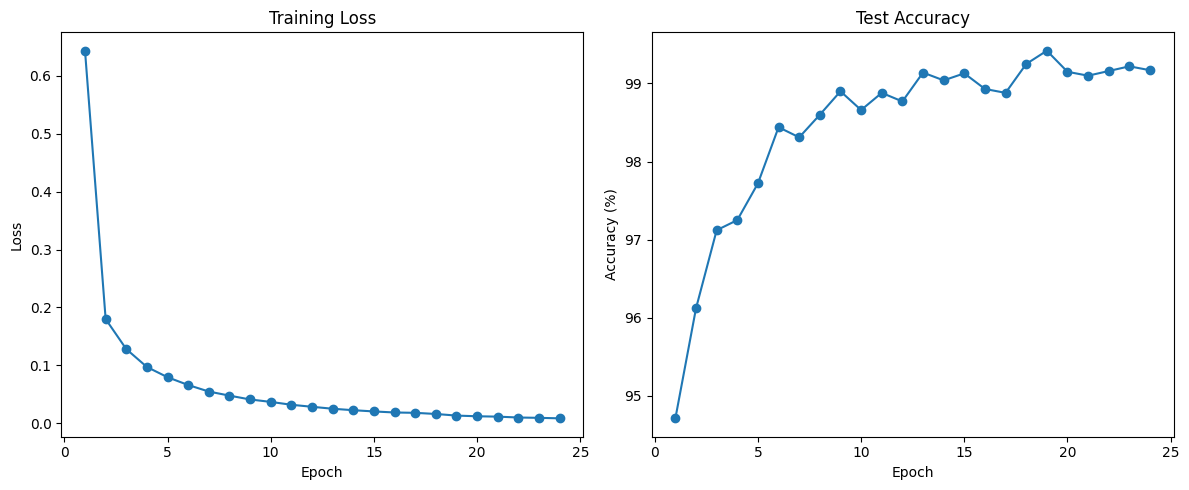

In [14]:
# Plotting training loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [15]:
# Print model architecture
print("Model Architecture:")
print(model)

Model Architecture:
BetterMNISTCNN(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


# Printing Layer-Wise Parameters:

Understanding each layer in a neural network is essential for monitoring and debugging the model. In this step, we print out the kernels for each layer in the model. This helps us understand how the weights are initialized and if they are being updated correctly during training.

The code loops through each layer of the model, printing:

Layer Name: The name of the layer.
Size: The shape of the kernels (e.g., weight matrix size for convolutional layers).

Values: A preview of the kernels values (the first two values from each parameter) to give a sense of how the weights are initialized.

This output is especially useful to verify that parameters are being properly learned and are not all zero or incorrectly initialized.



In [16]:
# Print layer-wise parameters
print("\nModel Parameters Per Layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()} | Values: {param.data[:2]}")  # Showing first two values as a preview


Model Parameters Per Layer:
Layer: cnn1.weight | Size: torch.Size([32, 1, 3, 3]) | Values: tensor([[[[-0.2565, -0.1196,  0.3089],
          [ 0.5042, -0.7147, -0.5852],
          [ 0.3951,  0.5537,  0.0693]]],


        [[[ 0.2935,  0.4846, -1.0028],
          [ 0.6087,  0.1836, -0.7623],
          [ 0.2144,  0.1878,  0.0613]]]], device='cuda:0')
Layer: cnn1.bias | Size: torch.Size([32]) | Values: tensor([0.0823, 0.1183], device='cuda:0')
Layer: cnn2.weight | Size: torch.Size([64, 32, 3, 3]) | Values: tensor([[[[-1.4477e-01,  8.7502e-02, -1.3884e-02],
          [ 9.5476e-02, -7.8313e-02,  6.3058e-02],
          [ 1.9132e-01,  1.0573e-01, -1.7569e-01]],

         [[-4.3815e-01, -7.0699e-02, -2.4564e-01],
          [-6.3537e-02, -1.4850e-01, -1.5691e-01],
          [ 2.4749e-01,  5.0763e-02, -3.2444e-02]],

         [[ 4.7512e-01,  1.0833e-01,  2.4974e-01],
          [ 4.0248e-01,  4.1145e-01,  4.1737e-01],
          [ 3.4069e-01,  2.3188e-01,  2.1177e-01]],

         [[-4.2411e-02, -7.

# Visualize the activation maps

To visualize the activation maps of the layers in your convolutional neural network, we can pass an image through the network and extract the feature maps (i.e., the activations) at each convolutional layer. These feature maps will show how the network is processing the image at each layer. Visualizing them helps to understand what kind of features are being detected at different stages of the network.

Helper function that hooks into the layers of the model and saves the activations during a forward pass.

In [17]:
# Hook function to capture the activations
def hook_fn(module, input, output):
    activation_maps.append(output)

# List to store the activations of the layers
activation_maps = []

# Register hooks for each convolutional layer
model.cnn1.register_forward_hook(hook_fn)
model.cnn2.register_forward_hook(hook_fn)
model.cnn3.register_forward_hook(hook_fn)

Next, we'll pass a single image from the dataset through the model and record the activations.

In [18]:
# Take one image from the test set
image, label = testset[6969]  # Use the first image in the test set
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Forward pass through the model
model(image)

# Now, 'activation_maps' will contain the activations from each layer


tensor([[ -4.6351,  19.0145,  -7.9089, -15.6746,   0.7788, -19.6352,  -2.8893,
           2.4510,  -7.7733, -15.8125]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Now that we have captured the activations, we can visualize them. We'll plot the activation maps for the three convolutional layers.

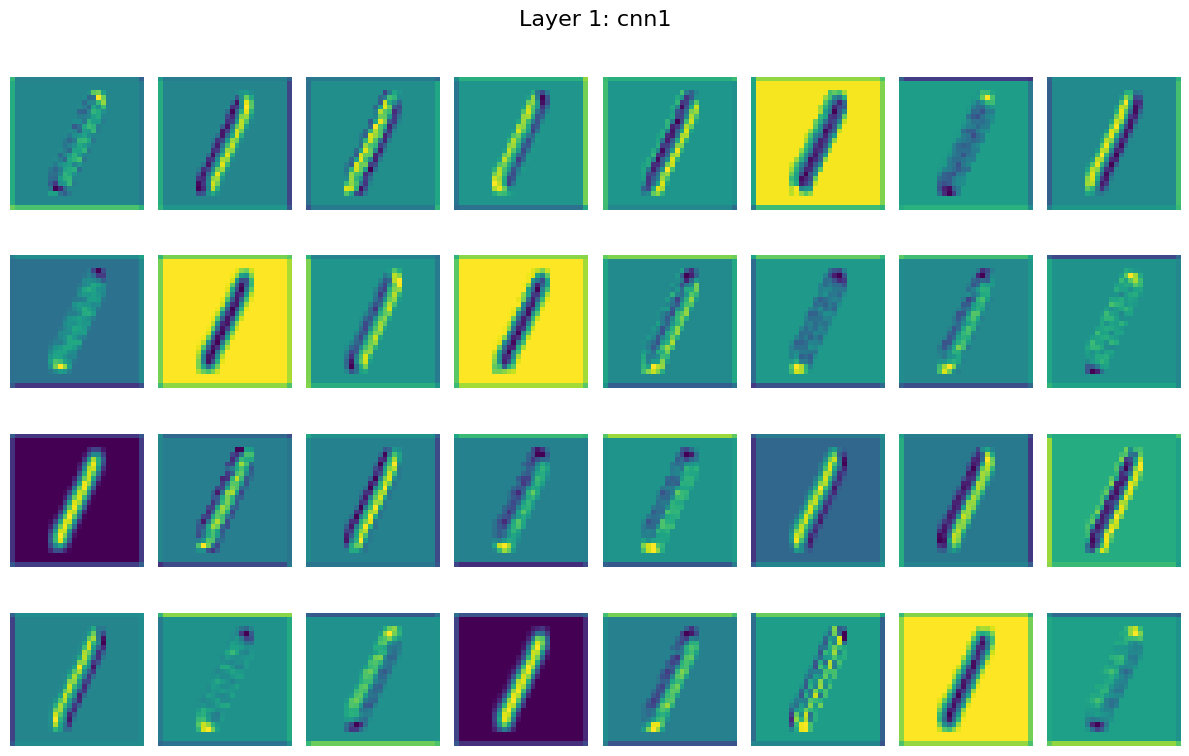

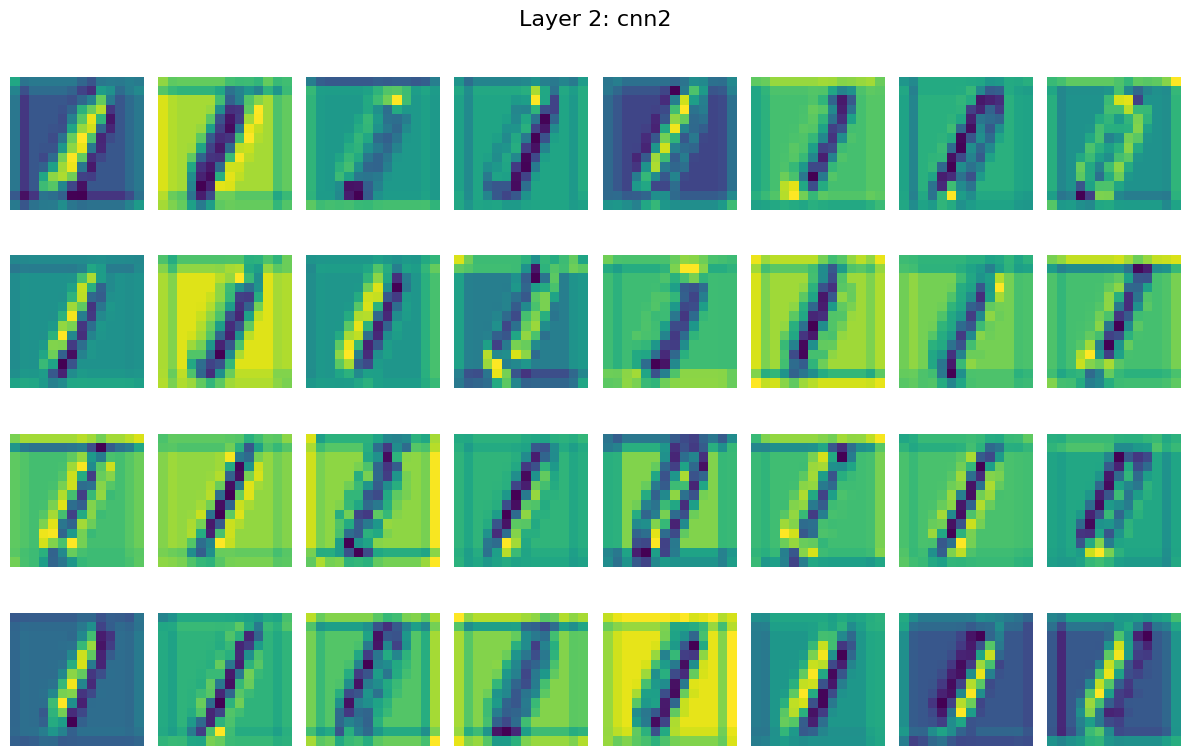

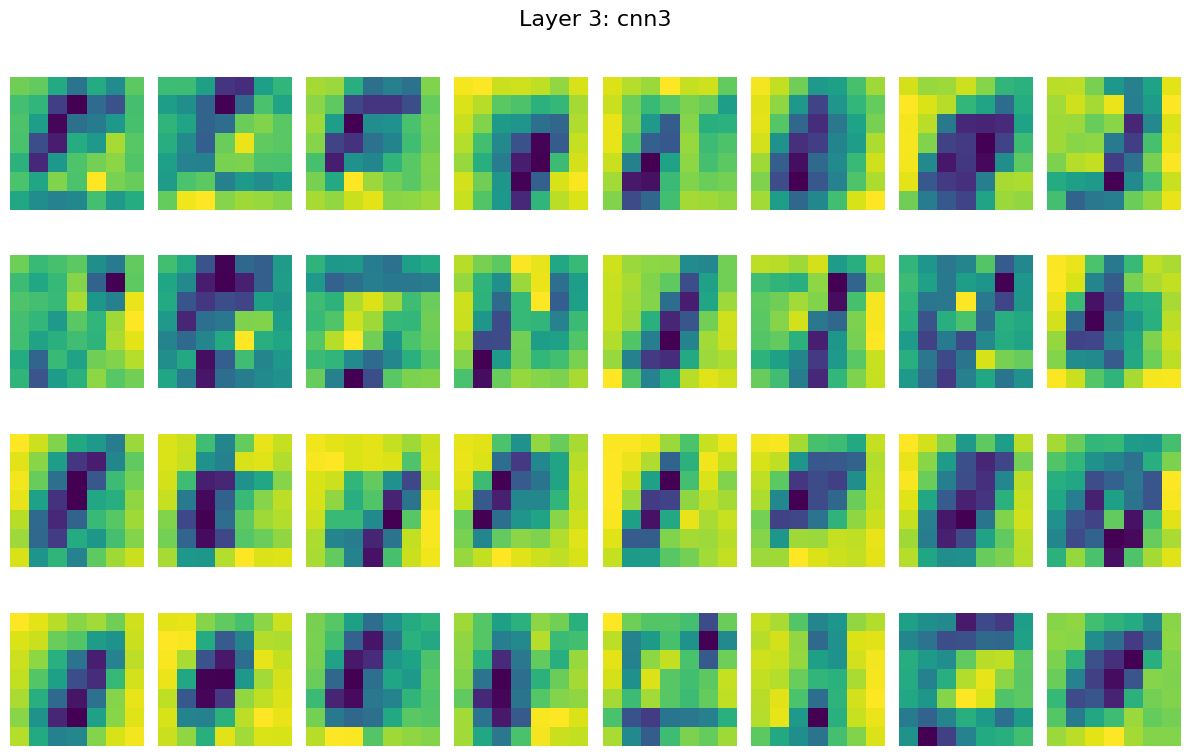

In [19]:
# Plotting activation maps of each convolutional layer
layer_titles = ['Layer 1: cnn1', 'Layer 2: cnn2', 'Layer 3: cnn3']
for i, activation in enumerate(activation_maps):
    num_filters = activation.size(1)  # Number of filters (channels)
    fig, axes = plt.subplots(4, 8, figsize=(12, 8))  # Create grid of subplots

    for j in range(min(num_filters, 32)):  # Display up to 32 filters
        ax = axes[j // 8, j % 8]
        ax.imshow(activation[0, j].cpu().detach().numpy(), cmap='viridis')  # Show activations
        ax.axis('off')

    plt.suptitle(layer_titles[i], fontsize=16)
    plt.tight_layout()
    plt.show()


# **Exploring Other CNN Architectures**

**Architecture Breakdown:**

This network is designed with a series of three convolutional blocks, followed by a fully connected (FC) layer. Let's look at each block in detail:

**First Block:**

**Conv2d Layer:** Takes in an image of size 28x28x1 (grayscale image) and applies 64 filters of size 3x3 to produce an output of 28x28x64.

**ReLU Activation:** Introduces non-linearity to the model, allowing it to learn complex patterns.

**Conv2d Layer:** Another convolutional layer with 64 filters of size 3x3, keeping the size of the feature map the same (28x28x64).

**MaxPool2d Layer:**Performs downsampling using a pool size of 2x2, reducing the spatial dimensions from 28x28x64 to 14x14x64.

**Batch Normalization:** Normalizes the activations of the previous layer to stabilize training and speed up convergence.

**Second Block:**

Conv2d Layer: Takes the output from the first block (14x14x64) and applies 128 filters of size 3x3, keeping the size the same (14x14x128).

ReLU Activation: Again, introducing non-linearity.

Conv2d Layer: Applies another 128 filters of size 3x3 to keep the size (14x14x128).

MaxPool2d Layer: Downsamples the feature map from 14x14x128 to 7x7x128.

Batch Normalization: Helps in stabilizing training by normalizing the outputs of the previous layer.

Third Block:

Conv2d Layer: Takes the feature map from the second block (7x7x128) and applies 256 filters of size 3x3, keeping the size the same (7x7x256).

MaxPool2d Layer: Reduces the spatial dimensions from 7x7x256 to 3x3x256.
Batch Normalization: Again, normalizes the **activations** to improve stability.

**Fully Connected (FC) Layer:**
Flatten: Flattens the feature map from 3x3x256 into a 1D vector of size 2304.
Linear Layer: Fully connected layer that reduces the dimension from 2304 to 512.
ReLU Activation: Applied to the output of the fully connected layer for non-linearity.

Model Details:
Optimizer: AdamW optimizer with weight decay is used. AdamW is an improved version of Adam, which decouples the weight decay from the optimization steps, helping to avoid overfitting.

Scheduler: A learning rate scheduler (StepLR) is implemented to decay the learning rate every 5 epochs by a factor of 0.9, allowing the model to converge smoothly over time.

Loss Function: CrossEntropyLoss is used since this is a classification problem with multiple classes (10 classes for MNIST).

In [20]:
class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        self.model = nn.Sequential(
            # First Block
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),  # Input: 28x28x1 -> 28x28x64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # Input: 28x28x64 -> 28x28x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Input: 28x28x64 -> 14x14x64
            nn.BatchNorm2d(64),

            # Second Block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # Input: 14x14x64 -> 14x14x128
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # Input: 14x14x128 -> 14x14x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Input: 14x14x128 -> 7x7x128
            nn.BatchNorm2d(128),

            # Third Block
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # Input: 7x7x128 -> 7x7x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Input: 7x7x256 -> 3x3x256
            nn.BatchNorm2d(256),

            # Fully Connected Layer
            nn.Flatten(),  # Flatten the feature map: 3x3x256 -> 2304
            nn.Linear(256 * 3 * 3, 512),  # Fully connected: 2304 -> 512
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PyTorchCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)  # AdamW with weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)  # Decay learning rate every 5 epochs


Epoch [1/24], Loss: 0.2479
Accuracy on the test set: 98.37%
Epoch [2/24], Loss: 0.0450
Accuracy on the test set: 98.92%
Epoch [3/24], Loss: 0.0397
Accuracy on the test set: 98.42%
Epoch [4/24], Loss: 0.0400
Accuracy on the test set: 98.83%
Epoch [5/24], Loss: 0.0355
Accuracy on the test set: 98.90%
Epoch [6/24], Loss: 0.0395
Accuracy on the test set: 98.69%
Epoch [7/24], Loss: 0.0321
Accuracy on the test set: 98.91%
Epoch [8/24], Loss: 0.0337
Accuracy on the test set: 98.90%
Epoch [9/24], Loss: 0.0348
Accuracy on the test set: 98.87%
Epoch [10/24], Loss: 0.0345
Accuracy on the test set: 98.75%
Epoch [11/24], Loss: 0.0362
Accuracy on the test set: 99.13%
Epoch [12/24], Loss: 0.0268
Accuracy on the test set: 98.99%
Epoch [13/24], Loss: 0.0234
Accuracy on the test set: 98.64%
Epoch [14/24], Loss: 0.0314
Accuracy on the test set: 99.01%
Epoch [15/24], Loss: 0.0307
Accuracy on the test set: 99.16%
Epoch [16/24], Loss: 0.0286
Accuracy on the test set: 98.95%
Epoch [17/24], Loss: 0.0289
Accur

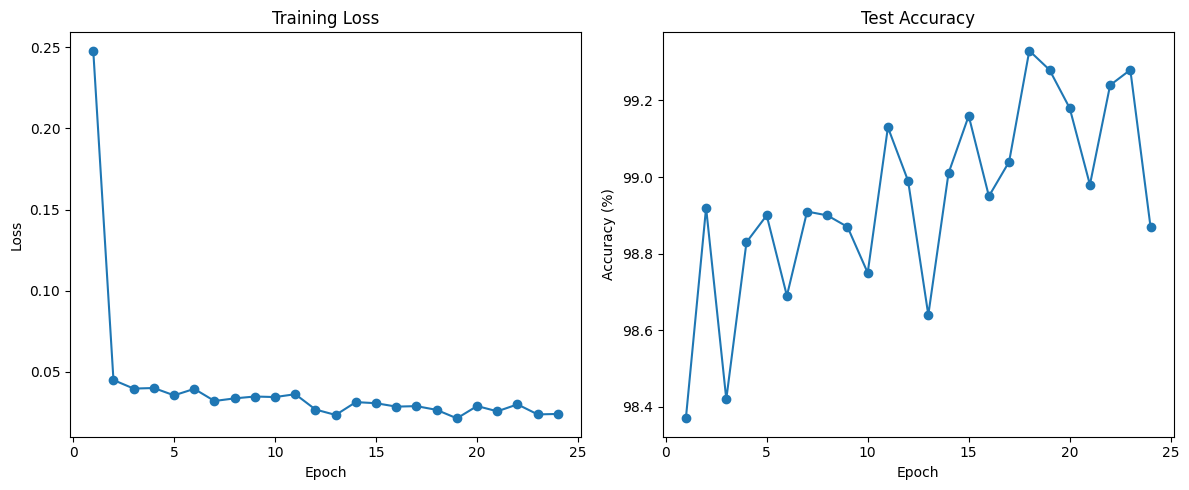

In [21]:
# Training loop
num_epochs = 24
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (CPU/GPU)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        # Accumulate the loss for monitoring
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    # Evaluation on the test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate test accuracy
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Accuracy on the test set: {accuracy:.2f}%')

# Plotting training loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Explanation of the AlexNet-Inspired CNN Architecture

In this section, we present an AlexNet-inspired convolutional neural network (CNN) model designed for the MNIST dataset. AlexNet is a famous deep learning model that revolutionized image classification. It consists of convolutional layers, max-pooling layers, fully connected layers, and dropout for regularization. Let's break down how this architecture works and how it is adapted for MNIST.

**Architecture Breakdown:**

**Convolutional Layers:**

conv1: The first convolutional layer takes the input image (size 28x28x1 for MNIST) and applies 64 filters of size 5x5, with a stride of 1 and padding of 2. This keeps the spatial dimensions the same (28x28). The output is a 28x28x64 feature map.

conv2: The second convolutional layer takes the previous output (28x28x64) and applies 192 filters of size 5x5, with padding of 2. The output is a 28x28x192 feature map.

conv3: The third convolutional layer takes the previous output (28x28x192) and applies 384 filters of size 3x3, with padding of 1. The output is a 28x28x384 feature map.

conv4: The fourth convolutional layer takes the previous output (28x28x384) and applies 256 filters of size 3x3, with padding of 1. The output is a 28x28x256 feature map.

conv5: The fifth convolutional layer takes the previous output (28x28x256) and applies 256 filters of size 3x3, with padding of 1. The output is a 28x28x256 feature map.

**Max Pooling:**

After each pair of convolutional layers, a MaxPool2d layer with a kernel size of 2x2 and stride of 2 is applied to downsample the feature maps by a factor of 2. This reduces the spatial dimensions progressively.

**Fully Connected Layers:**

fc1: The first fully connected layer takes the flattened output of the convolutional layers and maps it to a 4096-dimensional vector.

fc2: The second fully connected layer also has 4096 units, further processing the learned features.

fc3: The third fully connected layer is the output layer, which outputs a vector of size num_classes, where num_classes is set to 10 for MNIST.

**Dropout:**

Dropout is applied after each of the first two fully connected layers (fc1 and fc2) to regularize the model and reduce overfitting. The dropout probability is set to 0.5, meaning 50% of the neurons are randomly dropped during training.

In [22]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # First Convolutional Block (modified for MNIST)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)  # Adjusted kernel size and stride
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Max Pooling Layers (adjusted for smaller input size)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the size of the feature map after all convolutional layers and pooling
        self._compute_fc_input_size()

        # Fully Connected Layers (adjusted for smaller feature maps)
        self.fc1 = nn.Linear(self.fc_input_size, 4096)  # Adjusted based on the new feature map size
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)  # Output layer

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def _compute_fc_input_size(self):
        # Create a dummy tensor with size (1, 1, 28, 28) to simulate the input image (MNIST size)
        dummy_input = torch.zeros(1, 1, 28, 28)
        dummy_output = self._forward(dummy_input)
        self.fc_input_size = dummy_output.view(-1).size(0)

    def _forward(self, x):
        # Apply convolution layers with ReLU activations and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = self.pool(x)

        # Flatten the tensor before passing to fully connected layers
        return x

    def forward(self, x):
        x = self._forward(x)

        # Flatten the tensor before passing to fully connected layers
        x = x.view(x.size(0), -1)  # Flatten

        # Apply fully connected layers with ReLU activation and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)  # Output layer

        return F.log_softmax(x, dim=1)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)

# Loss function
criterion = nn.NLLLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)


AlexNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch [1/28], Loss: 0.2535
Accuracy on the test set: 98.57%
Epoch [2/28], Loss: 0.0551
Accuracy on the test set: 98.67%
Epoch [3/28], Loss: 0.0378
Accuracy on the test set: 98.93%
Epoch [4/28], Loss: 0.0279
Accuracy on the test set: 99.17%
Epoch [5/28], Loss: 0.0229
Accuracy on the test set: 99.23%
Epoch [6/28], Loss: 0.0195
Accuracy on the test set: 99.24%
Epoch [7/28], Loss: 0.0163
Accuracy on the test set: 99.44%
Epoch [8/28], Loss: 0.0136
Accuracy on the test set: 99.23%
Epoch [9/28], Loss: 0.0118
Accuracy on the test set: 99.29%
Epoch [10/28], Loss: 0.0102
Accuracy on the test set: 99.20%
Epoch [11/28], Loss: 0.0087
Accuracy on the test set: 99.30%
Epoch [12/28], Loss: 0.0093
Accuracy on the test set: 99.23%
Epoch [13/28], Loss: 0.0086
Accuracy on the test set: 99.33%
Epoch [14/28], Loss: 0.0071
Accuracy on the test set: 99.24%
Epoch [15/28], Loss: 0.0066
Accuracy on the test set: 99.16%
Epoch [16/28], Loss: 0.0059
Accuracy on the test set: 99.31%
Epoch [17/28], Loss: 0.0063
Accur

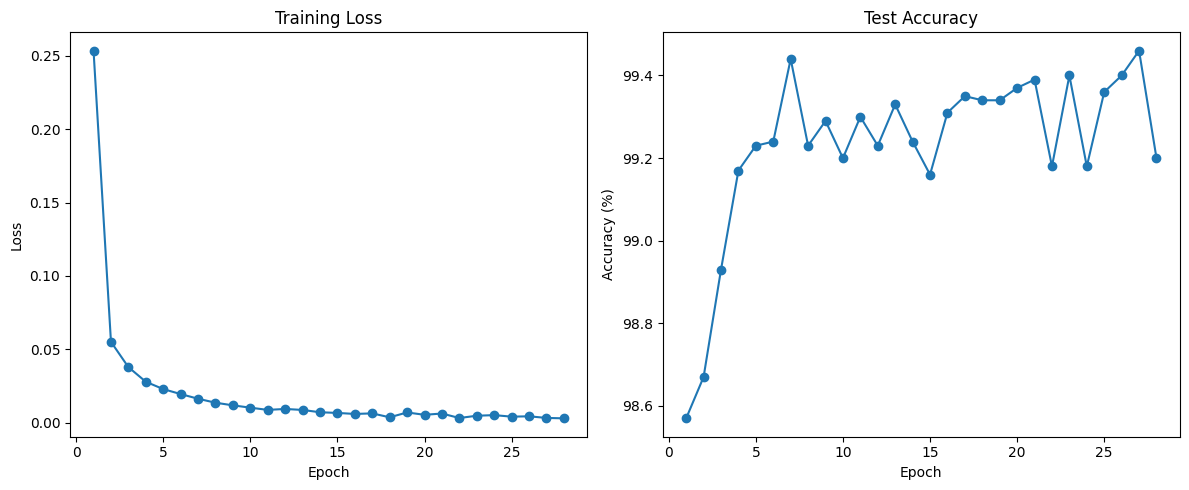

In [23]:
# Training loop
num_epochs = 28
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (CPU/GPU)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        # Accumulate the loss for monitoring
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    # Evaluation on the test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate test accuracy
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Accuracy on the test set: {accuracy:.2f}%')

# Plotting training loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()